# Topic 18 - Classifier Performance

In this demonstration we will continue on from where we started in topic 17. First we will train a classifier algorithm on the MNIST data set.

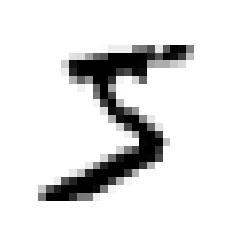

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

import matplotlib as mpl
import matplotlib.pyplot as plt

X, y = mnist["data"], mnist["target"]

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

import numpy as np
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

Here we will run a 3-fold cross validation on the classifier that we have trained using the training set. 

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

At first glance this looks good, with 90+% accuracy. This is hiding a very ineffective classifier. The problem is that the classifier has been trained and assessed on an unbalanced dataset. 

**Only about 10% of the dataset contains '5's.**

Lets construct a confusion matrix to see what is really happening. We will start by using `cross_val_predict( ... ) ` to test the classifier. This will return a list of the predictions made by the classifier.


In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now we can calculate a confusion matrix using the `confusion_matrix( ... )` function.

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

From the confuction matrix, it is evident that there are actually many mis-classifications.

Using the results from the confusion matrix, we can calculate some more concise metrics.
* *Precision* - the accuracy of the positive predictions.

$$
precision = TP / (TP + FP)
$$

* *Recall* (Sometimes called *Sensitivity*) - The ratio of positive instances that are correctly detected by the classifier. 

$$
recall = TP /(TP + FN)
$$

In [5]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred)) # == 3530 / (3530 + 1891)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (3530 + 687)


0.8370879772350012
0.6511713705958311


When the classifier claims a value is a 5, it is only correct 83% of the time (Precision).
The classifier only detects 65% of the 5s in the dataset 

Precision and recall can be summarized by calculating the *F1* score:

$$
F1 = TP / (TP + ((FN+FP)/2))
$$

In [6]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score summarises the recall and precision. This produces a harmonic mean that is only high if *both* the recall and precision are high.  

In [9]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

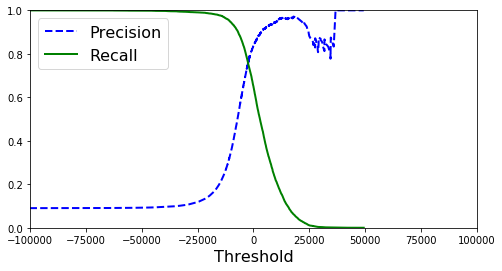

In [12]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-100000, 100000])
plt.show()


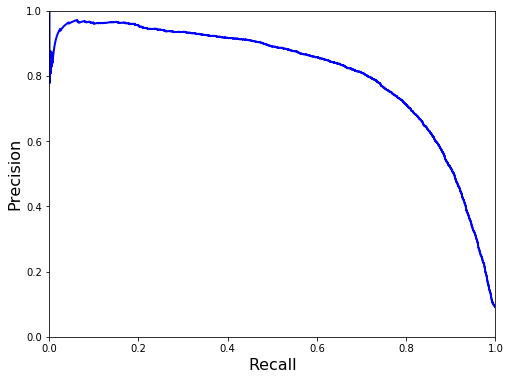

In [14]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [15]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

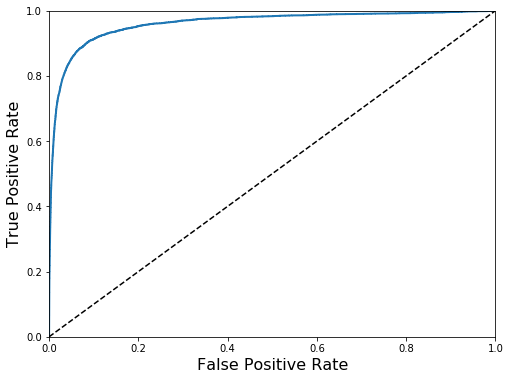

In [16]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616